# PySINDy Package Feature Overview

This notebook provides a simple overview of the basic functionality of the PySINDy software package. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

In [3]:
# Seed the random number generators for reproducibility
np.random.seed(100)

## Basic usage

In [ ]:
def roessler(z, t):
    return [
        -z[1] - z[2],
        z[0] + 0.2 * z[1],
        0.1 + z[0] * z[2] - 5.3 * z[2]
    ]
sys = roessler

In [4]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]
    sys = lorenz

### Train the model

In [7]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 3, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
# print(x_train)
print(x_train.shape)

(300, 3)


In [11]:
lorenz(x0_train,1)


[160, -16, -136.0]

In [6]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

x0' = -9.987 x0 + 9.986 x1
x1' = 27.833 x0 + -0.972 x1 + -0.995 x0 x2
x2' = -2.661 x2 + 0.998 x0 x1


In [51]:
x_train.shape

(300, 3)

In [38]:
model.coefficients()

array([[ 0.        , -9.99921   ,  9.9992091 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 27.99216493, -0.99850339,  0.        ,  0.        ,
         0.        , -0.99977897,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -2.66636139,  0.        ,
         0.99988338,  0.        ,  0.        ,  0.        ,  0.        ]])

### Assess results on a test trajectory

In [56]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.999845


### Predict derivatives with learned model

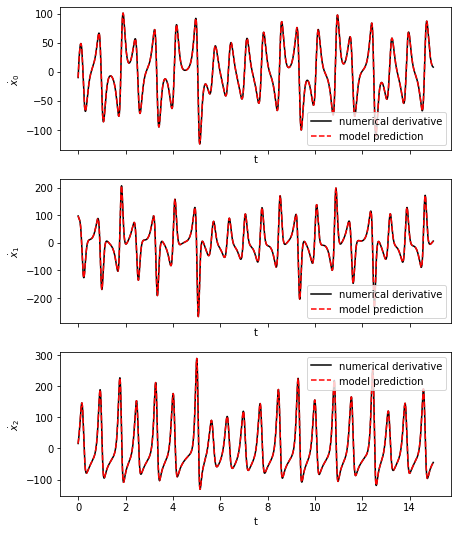

In [8]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time

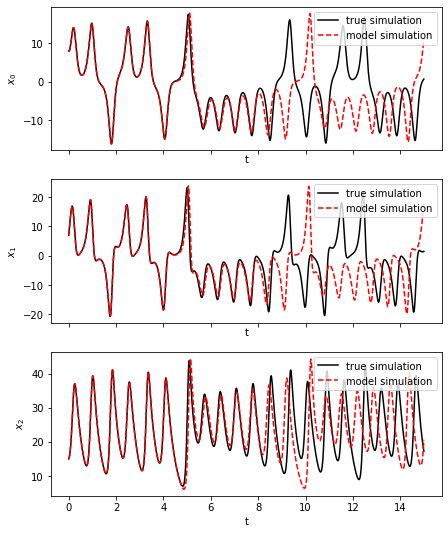

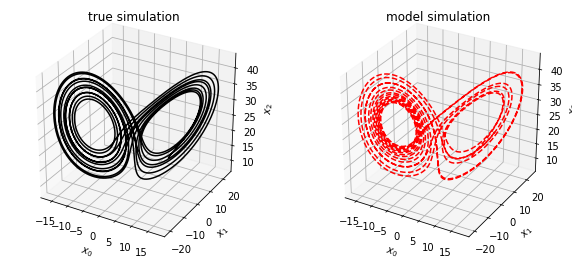

In [9]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

## Different forms of input data

Here we explore different types of input data accepted by the the `SINDy` class.

### Single trajectory, pass in collection times

In [10]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Single trajectory, pass in pre-computed derivatives

In [11]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(x_train[i], t_train[i])
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


### Multiple trajectories
We use the Lorenz equations to evolve multiple different initial conditions forward in time, passing all the trajectories into a single `SINDy` object. Note that `x_train_multi` is a list of 2D numpy arrays.

In [12]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(odeint(lorenz, x0s[i], t_train))

model = ps.SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Multiple trajectories, different lengths of time
This example is similar to the previous one, but each trajectory consists of a different number of measurements.

In [13]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1500)
    t = np.arange(0, n_samples * dt, dt)
    x_train_multi.append(odeint(lorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.994 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Discrete time dynamical system (map)

In [14]:
def f(x):
    return 3.6 * x * (1 - x)


n_steps = 1000
eps = 0.001  # Noise level
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1, n_steps):
    x_train_map[i] = f(x_train_map[i - 1]) + eps * np.random.randn()

model = ps.SINDy(discrete_time=True)
model.fit(x_train_map)
model.print()

x0[k+1] = 3.600 x0[k] + -3.600 x0[k]^2


### Pandas DataFrame

In [15]:
import pandas as pd

# Create a dataframe with entries corresponding to measurements and
# indexed by the time at which the measurements were taken
df = pd.DataFrame(data=x_train, columns=['x', 'y', 'z'], index=t_train)

# The column names can be used as feature names
model = ps.SINDy(feature_names=df.columns)

# Everything needs to be converted to numpy arrays to be passed in
model.fit(df.values, t=df.index.values)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.999 y + -1.000 x z
z' = -2.666 z + 1.000 x y


## Optimization options
In this section we provide examples of different parameters accepted by the built-in methods `STLSQ` and `SR3`. We also show how to use a scikit-learn sparse regressor with PySINDy.

### STLSQ - change parameters

In [16]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### SR3

In [17]:
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

model = ps.SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

convergence after 1 iterations
x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### LASSO
In this example we use a third-party Lasso implementation (from scikit-learn) as the optimizer.

In [18]:
lasso_optimizer = Lasso(alpha=100, fit_intercept=False)

model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -0.310 x0 x2 + 0.342 x1 x2 + -0.002 x2^2
x1' = 15.952 x1 + 0.009 x0 x1 + -0.219 x0 x2 + -0.474 x1 x2 + 0.007 x2^2
x2' = 0.711 x0^2 + 0.533 x0 x1 + -0.005 x1 x2 + -0.119 x2^2


## Differentiation options

### Pass in pre-computed derivatives

In [19]:
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Drop end points from finite difference computation

In [20]:
fd_dropEndpoints = ps.FiniteDifference(drop_endpoints=True)
    
model = ps.SINDy(differentiation_method=fd_dropEndpoints)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


### Smoothed finite difference

In [21]:
smoothedFD = ps.SmoothedFiniteDifference()
    
model = ps.SINDy(differentiation_method=smoothedFD)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Feature libraries

### Custom feature names

In [22]:
feature_names = ['x', 'y', 'z']
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.999 y + -1.000 x z
z' = -2.666 z + 1.000 x y


### Custom left hand side when printing the model

In [23]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt', 'dx1/dt', 'dx2/dt'])

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1


### Customize polynomial library

In [24]:
poly_library = ps.PolynomialLibrary(include_interaction=False)

model = ps.SINDy(feature_library=poly_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -72.092 1 + -13.015 x0 + 9.230 x1 + 9.452 x2 + 0.598 x0^2 + -0.289 x1^2 + -0.247 x2^2
x2' = -41.053 1 + 0.624 x0 + -0.558 x1 + 2.866 x2 + 1.001 x0^2 + 0.260 x1^2 + -0.176 x2^2


### Fourier library

In [25]:
fourier_library = ps.FourierLibrary(n_frequencies=3)

model = ps.SINDy(feature_library=fourier_library)
model.fit(x_train, t=dt)
model.print()

x0' = 0.361 sin(1 x0) + 1.015 cos(1 x0) + 6.068 cos(1 x1) + -2.618 sin(1 x2) + 4.012 cos(1 x2) + -0.468 cos(2 x0) + -0.326 sin(2 x1) + -0.883 cos(2 x1) + 0.353 sin(2 x2) + 0.281 cos(2 x2) + 0.436 sin(3 x0) + 0.134 cos(3 x0) + 2.860 sin(3 x1) + 0.780 cos(3 x1) + 2.413 sin(3 x2) + -1.869 cos(3 x2)
x1' = -2.693 sin(1 x0) + -4.096 cos(1 x0) + -0.425 sin(1 x1) + 0.466 cos(1 x1) + -4.697 sin(1 x2) + 7.946 cos(1 x2) + -1.108 sin(2 x0) + -5.631 cos(2 x0) + -1.089 sin(2 x1) + -1.079 cos(2 x1) + 3.288 sin(2 x2) + 1.151 cos(2 x2) + 1.949 sin(3 x0) + 4.829 cos(3 x0) + -0.555 sin(3 x1) + 0.635 cos(3 x1) + 4.257 sin(3 x2) + -3.065 cos(3 x2)
x2' = 5.015 sin(1 x0) + 4.775 cos(1 x0) + 5.615 sin(1 x1) + -3.112 cos(1 x1) + -1.019 sin(1 x2) + 0.345 cos(1 x2) + 2.535 sin(2 x0) + 2.008 cos(2 x0) + -4.250 sin(2 x1) + -13.784 cos(2 x1) + -0.797 sin(2 x2) + 2.578 sin(3 x0) + -0.399 cos(3 x0) + 5.208 sin(3 x1) + -8.286 cos(3 x1) + 0.720 sin(3 x2) + -0.229 cos(3 x2)


### Fully custom library
The `CustomLibrary` class gives you the option to pass in function names to improve the readability of the printed model. Each function "name" should itself be a function.

In [26]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 1.407 1/x0 + -48.091 1/x2 + -12.472 x0 + 9.296 x1 + 0.381 x2 + 0.879 sin(x0,x1) + 1.896 sin(x0,x2) + -0.468 sin(x1,x2)
x2' = 1.094 1/x0 + -7.674 1/x2 + 0.102 x0 + 0.157 x1 + 3.603 sin(x0,x1) + -3.323 sin(x0,x2) + -3.047 sin(x1,x2)


### Fully custom library, default function names
If no function names are given, default ones are given: `f0`, `f1`, ...

In [27]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

x0' = -9.999 f2(x0) + 9.999 f2(x1)
x1' = 1.407 f1(x0) + -48.091 f1(x2) + -12.472 f2(x0) + 9.296 f2(x1) + 0.381 f2(x2) + 0.879 f3(x0,x1) + 1.896 f3(x0,x2) + -0.468 f3(x1,x2)
x2' = 1.094 f1(x0) + -7.674 f1(x2) + 0.102 f2(x0) + 0.157 f2(x1) + 3.603 f3(x0,x1) + -3.323 f3(x0,x2) + -3.047 f3(x1,x2)


### Identity library

In [28]:
identity_library = ps.IdentityLibrary()

model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -12.451 x0 + 9.314 x1 + 0.299 x2
x2' = 0.159 x0 + 0.101 x1
